<a href="https://colab.research.google.com/github/ezeochris/ws-eng-conduit-ai-assessment/blob/master/Phishing_Detection_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rearranged Sequence with Missteps
Updated Timeline (August 3–22, 2025):

Day 1–2 (Aug 3–4): Step 1: Set Up Environment (~2 hours).

Sub-Task 1: Create Colab Notebook.
Sub-Task 2: Install Dependencies (scikit-learn, pandas, numpy, textattack, shap, lime, treeinterpreter, xgboost, beautifulsoup4).
Sub-Task 3: Download PhishTank (~3,500 phishing URLs).
Sub-Task 4: Download Nazario/Mendeley (3,500 phishing emails, 3,500 legitimate URLs from index.sql, 3,523 synthetic emails).


Day 3–5 (Aug 5–7): Step 2: Preprocess Datasets.

Extract features, combine into combined_data.csv, address ineffective perturbations.


Day 6 (Aug 8): Step 3: Train Random Forest and XGBoost.
Day 7–8 (Aug 9–10): Step 4: Simulate Adversarial Attacks (initial and stronger with textattack/beautifulsoup4).
Day 9 (Aug 11): Step 5: Retrain Random Forest.
Day 10–11 (Aug 12–13): Step 6: Apply SHAP (skip LIME/TreeInterpreter unless used).
Day 12 (Aug 14): Step 7: Evaluate Metrics (zero-trust context).
Day 13 (Aug 15): Step 8: Buffer for Troubleshooting.
Day 14–20 (Aug 16–22): Paper Writing (include missteps, zero-trust framing).

Adjustments:

Replaced EvilEmail with Nazario/Mendeley, matching updated Methodology.
Reduced PhishTank to 3,500 (per Methodology) to balance datasets.
Added beautifulsoup4 for perturbations, optional textattack.
Integrated XGBoost as a baseline, zero-trust framing in evaluation

In [ ]:
print("Colab is working!")

## 1.2 Installing dependenies

In [8]:
!pip install scikit-learn pandas numpy textattack shap lime treeinterpreter xgboost beautifulsoup4

## 1.3 Downloading Phistank Dataset

In [9]:
import pandas as pd; urls = pd.read_csv('phishtank_urls.csv'); print(urls.shape); print(urls.head())

(43516, 8)
   phish_id                                                url  \
0   9135651  https://defichainresolve.vercel.app/connect/co...   
1   9135648   https://aeon-pheno.fgxqh.cn/openirt-connect/app/   
2   9135642  https://apple-com.r5xtq.com/UgYL20/?support=wR...   
3   9135629  https://pckd0ory8y-r7f8g4-top.translate.goog/t...   
4   9135628  https://pckd0ory8y-yg9pou-top.translate.goog/t...   

                                    phish_detail_url  \
0  http://www.phishtank.com/phish_detail.php?phis...   
1  http://www.phishtank.com/phish_detail.php?phis...   
2  http://www.phishtank.com/phish_detail.php?phis...   
3  http://www.phishtank.com/phish_detail.php?phis...   
4  http://www.phishtank.com/phish_detail.php?phis...   

             submission_time verified          verification_time online target  
0  2025-06-24T02:08:01+00:00      yes  2025-06-24T02:11:51+00:00    yes  Other  
1  2025-06-24T02:00:55+00:00      yes  2025-06-24T02:11:51+00:00    yes  Other  
2  2025-06-2


**Extracting 3500 dataset from the 43516 in phistank dataset to save it as phishtank_urls_3500.csv**

In [10]:
import pandas as pd
urls = pd.read_csv('phishtank_urls.csv')
# Limit to 3500 verified phishing URLs
urls = urls[urls['verified'] == 'yes'].tail(3500)
print("PhishTank URLs shape:", urls.shape)
print("\nHead:\n", urls.head())
urls.to_csv('phishtank_urls_3500.csv', index=False)

PhishTank URLs shape: (3500, 8)

Head:
        phish_id                                                url  \
40016   8426842  https://docs.google.com/presentation/d/e/2PACX...   
40017   8426841  https://docs.google.com/presentation/d/e/2PACX...   
40018   8426840  https://docs.google.com/presentation/d/e/2PACX...   
40019   8426839  https://docs.google.com/presentation/d/e/2PACX...   
40020   8426725         https://rmessage29.wixsite.com:443/my-site   

                                        phish_detail_url  \
40016  http://www.phishtank.com/phish_detail.php?phis...   
40017  http://www.phishtank.com/phish_detail.php?phis...   
40018  http://www.phishtank.com/phish_detail.php?phis...   
40019  http://www.phishtank.com/phish_detail.php?phis...   
40020  http://www.phishtank.com/phish_detail.php?phis...   

                 submission_time verified          verification_time online  \
40016  2024-01-24T13:35:14+00:00      yes  2024-01-24T13:42:54+00:00    yes   
40017  2024-01-24T13

Downloading Nazario Dataset

In [11]:
!wget --no-check-certificate https://monkey.org/~jose/phishing/private-phishing4.mbox -O private-phishing4.mbox

--2025-08-06 02:39:56--  https://monkey.org/~jose/phishing/private-phishing4.mbox
Resolving monkey.org (monkey.org)... 104.197.149.9
Connecting to monkey.org (monkey.org)|104.197.149.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32736139 (31M) [application/mbox]
Saving to: ‘private-phishing4.mbox’

private-phishing4.m 100%[===================>]  31.22M  83.9MB/s    in 0.4s    

2025-08-06 02:39:56 (83.9 MB/s) - ‘private-phishing4.mbox’ saved [32736139/32736139]



In [12]:
!ls -lh private-phishing4.mbox

-rw-r--r-- 1 root root 32M Jul 24  2018 private-phishing4.mbox


convert mbox into csv and renaming it to evilmail




In [13]:
import email
import pandas as pd
from email.policy import default

emails = []
try:
    with open('private-phishing4.mbox', 'rb') as f:
        mbox_content = f.read()
        messages = mbox_content.split(b'\nFrom ')[1:]  # Skip empty first split
        for i, msg_bytes in enumerate(messages):
            try:
                msg_bytes = b'From ' + msg_bytes
                msg = email.message_from_bytes(msg_bytes, policy=default)
                subject = msg['subject'] or ''
                sender = msg['from'] or ''
                if isinstance(subject, bytes): subject = subject.decode('utf-8', errors='replace')
                if isinstance(sender, bytes): sender = sender.decode('utf-8', errors='replace')
                payload = msg.get_payload()
                if isinstance(payload, list):
                    payload = ''.join(part.get_payload(decode=True).decode('utf-8', errors='replace') if part.get_payload(decode=True) else '' for part in payload)
                elif isinstance(payload, bytes):
                    payload = payload.decode('utf-8', errors='replace')
                else:
                    payload = str(payload) or ''
                emails.append({'subject': subject, 'sender': sender, 'message': payload, 'label': 1})
            except Exception as e:
                print(f"Skipping email {i} due to error: {e}")
                continue
except Exception as e:
    print(f"Error reading mbox file: {e}")

emails_df = pd.DataFrame(emails)
emails_df.to_csv('evil_email.csv', index=False, encoding='utf-8')
print("Nazario Emails shape:", emails_df.shape)
print("\nHead:\n", emails_df.head())

Skipping email 236 due to error: 'str' object has no attribute 'token_type'
Skipping email 287 due to error: 'str' object has no attribute 'token_type'
Skipping email 291 due to error: 'str' object has no attribute 'token_type'
Skipping email 300 due to error: 'str' object has no attribute 'token_type'
Skipping email 306 due to error: 'str' object has no attribute 'token_type'
Skipping email 628 due to error: 'str' object has no attribute 'token_type'
Skipping email 711 due to error: 'str' object has no attribute 'token_type'
Skipping email 716 due to error: 'str' object has no attribute 'token_type'
Skipping email 1015 due to error: 'str' object has no attribute 'token_type'
Skipping email 1191 due to error: 'str' object has no attribute 'token_type'
Nazario Emails shape: (3523, 4)

Head:
                                              subject  \
0  Citizens Bank and Charter One Bank reminder: p...   
1  eBay New Message Received from Seller for Item...   
2  Citizens Bank and Charter O

vERIFYING EVILMAIL OUTPUT

In [14]:
import pandas as pd
emails = pd.read_csv('evil_email.csv')
print("Shape:", emails.shape)
print("\nHead:\n", emails.head())
print("\nSample message:\n", emails['message'].iloc[0][:500])  # First 500 chars of first message
print("\nLabel counts:\n", emails['label'].value_counts())
print("\nMissing values:\n", emails.isnull().sum())

Shape: (3523, 4)

Head:
                                              subject  \
0  Citizens Bank and Charter One Bank reminder: p...   
1  eBay New Message Received from Seller for Item...   
2  Citizens Bank and Charter One Bank customer se...   
3  IMPORTANT: PayPal Security Measures PP-052-CA-788   
4  PayPal Notification: Re: Unauthorized Use of Y...   

                                              sender  \
0  Citizens Bank and Charter One Bank <corporatec...   
1                         eBay <aw-confirm@ebay.com>   
2  Citizens Bank and Charter One Bank <corporatec...   
3                PayPal Service <service@paypal.com>   
4                        paypal <service@paypal.com>   

                                             message  label  
0  <head>\n<meta      http-equiv="Content-Type" c...      1  
1  <TABLE cellSpacing=0 cellPadding=5 width="100%...      1  
2  <head>\n<meta  http-equiv="Content-Type"     c...      1  
3  <html>\n<head>\n \n<title>Untitled Document</t... 

**1.1 Parsing Legitimate URLs from index.sql**
Description: Extract 3,500 legitimate URLs (label=0) from the Mendeley Phishing Websites Dataset’s index.sql file, compute features (length, special characters, login presence, HTTPS presence), and save to legit_urls_features.csv.

In [15]:
import pandas as pd
import re

# Function to parse multi-row VALUES
def parse_sql_values(line, line_num):
    # Match VALUES tuples like (1, 'url', 'website', 0, 'date')
    pattern = r"\(\s*(\d+)\s*,\s*'([^']*)'\s*,\s*'([^']*)'\s*,\s*(\d+)\s*,\s*'([^']*)'\s*\)(?:,|;)"
    matches = re.finditer(pattern, line.strip())
    results = []
    for match in matches:
        rec_id, url, website, result, created_date = match.groups()
        if int(result) == 0:  # Only keep legitimate URLs
            results.append({'url': url, 'result': int(result)})
        print(f"Line {line_num}: Matched url={url}, result={result}")
    return results

# Parse index.sql
try:
    data = []
    max_urls = 3500
    with open('index.sql', 'r', encoding='utf-8') as sql_file:
        in_values_block = False
        for i, line in enumerate(sql_file, 1):
            if len(data) >= max_urls:
                break
            line = line.strip()
            if line.startswith('INSERT INTO `index`'):
                in_values_block = True
                print(f"Line {i}: Found INSERT INTO")
                continue
            if in_values_block and line:
                parsed = parse_sql_values(line, i)
                data.extend(parsed)
                if line.endswith(';'):
                    in_values_block = False

    if not data:
        print("Error: No legitimate URLs found. Switching to synthetic URLs.")
        raise Exception("No legitimate URLs parsed")

    df = pd.DataFrame(data)
    print("Initial shape:", df.shape)
    print("\nColumns:", df.columns)

    # Ensure 3,500 URLs
    legit_urls = df.head(max_urls)
    print("Legitimate URLs shape:", legit_urls.shape)

    # Compute features
    legit_urls['length'] = legit_urls['url'].apply(len)
    legit_urls['special_chars'] = legit_urls['url'].apply(lambda x: sum(x.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'))
    legit_urls['has_login'] = legit_urls['url'].apply(lambda x: 1 if 'login' in str(x).lower() else 0)
    legit_urls['has_https'] = legit_urls['url'].apply(lambda x: 1 if 'https' in str(x).lower() else 0)
    legit_urls['label'] = 0
    legit_urls['type'] = 'url'
    legit_urls['text'] = legit_urls['url']

    # Select columns
    legit_urls = legit_urls[['text', 'label', 'length', 'special_chars', 'has_login', 'has_https', 'type']]
    print("Processed legitimate URLs shape:", legit_urls.shape)
    print("\nHead:\n", legit_urls.head())
    legit_urls.to_csv('legit_urls_features.csv', index=False, encoding='utf-8')

except FileNotFoundError:
    print("Error: index.sql not found. Please upload to Colab.")
    exit()
except Exception as e:
    print(f"Error parsing index.sql: {e}. Switching to synthetic URLs.")
    # Fallback to synthetic URLs
    domains = ['google.com', 'microsoft.com', 'apple.com', 'amazon.com', 'facebook.com', 'twitter.com', 'linkedin.com', 'github.com', 'stackoverflow.com']
    paths = ['', '/home', '/about', '/login', '/contact', '/products', '/services']
    protocols = ['https://', 'http://']
    legit_urls = []
    for _ in range(3500):
        protocol = random.choice(protocols)
        domain = random.choice(domains)
        path = random.choice(paths)
        url = f"{protocol}{domain}{path}"
        features = {
            'text': url,
            'label': 0,
            'length': len(url),
            'special_chars': sum(url.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'),
            'has_login': 1 if 'login' in url.lower() else 0,
            'has_https': 1 if 'https' in url.lower() else 0,
            'type': 'url'
        }
        legit_urls.append(features)
    legit_urls_df = pd.DataFrame(legit_urls)
    print("Synthetic legitimate URLs shape:", legit_urls_df.shape)
    print("\nHead:\n", legit_urls_df.head())
    legit_urls_df.to_csv('legit_urls_features.csv', index=False, encoding='utf-8')

Streaming output truncated to the last 5000 lines.
Line 531: Matched url=https://visihow.com/Recover_a_Lost_Password_on_Classmates_or_Odnoklassniki_on_iPhone_6, result=0
Line 532: Matched url=https://viabcpzonasegurabeta.pe.imaclone.host/personas/activa/tus/operaciones/en/linea/id3216548964/iniciar-sesion, result=1
Line 533: Matched url=https://spark.adobe.com/make/images/remove-background/, result=0
Line 534: Matched url=https://www.windingroad.com/articles/blogs/the-10-best-auto-racing-helmets/, result=0
Line 535: Matched url=https://www.uofmhealth.org/health-library/hw202058, result=0
Line 536: Matched url=https://lloydsinternational.help-je.com/Login.php, result=1
Line 537: Matched url=https://kiddo.edu.au/skills/two-handed-striking, result=0
Line 538: Matched url=https://www.brookings.edu/blog/techtank/2015/07/02/cuba-slowly-expands-internet-access/, result=0
Line 539: Matched url=https://www.instyle.com/account/signin?regSource=21023&returnURL=https%3A%2F%2Fwww.instyle.com%2Fcele

/tmp/ipython-input-4020014273.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legit_urls['length'] = legit_urls['url'].apply(len)
/tmp/ipython-input-4020014273.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legit_urls['special_chars'] = legit_urls['url'].apply(lambda x: sum(x.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'))
/tmp/ipython-input-4020014273.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v


1.2 Generating Synthetic Non-Phishing Emails

Description: Generate 3,523 synthetic non-phishing emails to balance the 3,523 phishing emails from the Nazario dataset, compute features, and save to non_phishing_features.csv.


In [16]:
import pandas as pd
import random

subjects = ["Meeting tomorrow", "Project update", "Newsletter", "Welcome!", "Team lunch"]
bodies = [
    "Hi, let's meet at 10 AM to discuss the project.",
    "Here's the latest update on our work. All good!",
    "Subscribe to our newsletter for updates.",
    "Welcome to our platform! Explore our features.",
    "Join us for lunch this Friday at 12 PM."
]
non_phishing_emails = []
for _ in range(3523):
    message = f"Subject: {random.choice(subjects)}\n\n{random.choice(bodies)}"
    text = str(message)
    features = {
        'text': text,
        'label': 0,
        'length': len(text),
        'special_chars': sum(text.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'),
        'has_login': 1 if 'login' in text.lower() else 0,
        'has_https': 1 if 'https' in text.lower() else 0,
        'type': 'email'
    }
    non_phishing_emails.append(features)

non_phishing_df = pd.DataFrame(non_phishing_emails)
print("Non-phishing emails shape:", non_phishing_df.shape)
print("\nHead:\n", non_phishing_df.head())
non_phishing_df.to_csv('non_phishing_features.csv', index=False, encoding='utf-8')

Non-phishing emails shape: (3523, 7)

Head:
                                                 text  label  length  \
0  Subject: Newsletter\n\nSubscribe to our newsle...      0      61   
1  Subject: Welcome!\n\nHere's the latest update ...      0      66   
2  Subject: Team lunch\n\nSubscribe to our newsle...      0      61   
3  Subject: Project update\n\nSubscribe to our ne...      0      65   
4  Subject: Welcome!\n\nWelcome to our platform! ...      0      65   

   special_chars  has_login  has_https   type  
0              2          0          0  email  
1              4          0          0  email  
2              2          0          0  email  
3              2          0          0  email  
4              4          0          0  email  


# Preprocessing datasets



Load and Clean PhishTank Dataset

In [17]:
import pandas as pd
urls = pd.read_csv('phishtank_urls.csv')
print("Columns:", urls.columns)
print("Initial shape:", urls.shape)
# Inspect verified column values
print("Unique verified values:", urls['verified'].unique())
# Filter verified URLs (adjust based on unique values)
# Try 'yes', 'True', or case variations
urls = urls[urls['verified'].str.lower().isin(['yes', 'y', 'true'])]
print("Verified shape:", urls.shape)
# Sample available URLs (aim for ~3,500 to balance with 3,523 emails)
n_samples = min(3500, len(urls))
if n_samples > 0:
    urls = urls[['url']].sample(n=n_samples, random_state=42, replace=True)
    urls['label'] = 1  # Phishing
else:
    print("No verified URLs found. Using all URLs with label=1.")
    urls = urls[['url']].sample(n=3500, random_state=42, replace=True)
    urls['label'] = 1
print("Final shape:", urls.shape)
print("\nHead:\n", urls.head())
urls.to_csv('phishtank_clean.csv', index=False, encoding='utf-8')

Columns: Index(['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified',
       'verification_time', 'online', 'target'],
      dtype='object')
Initial shape: (43516, 8)
Unique verified values: ['yes']
Verified shape: (43516, 8)
Final shape: (3500, 2)

Head:
                                              url  label
15795  https://web-m--logon--l-edger.webflow.io/      1
860          https://blinq.me/9eQa6B57rHih?bs=db      1
38158              http://tinyurl.com/btmail2229      1
11284          https://renouvellement-colis.com/      1
6265                  https://ghtyf1.weebly.com/      1


verifing phishtan_clean.csv

In [18]:
import pandas as pd
urls = pd.read_csv('phishtank_clean.csv')
print("Shape:", urls.shape)
print("\nHead:\n", urls.head())
print("\nLabel counts:\n", urls['label'].value_counts())
print("\nMissing values:\n", urls.isnull().sum())

Shape: (3500, 2)

Head:
                                          url  label
0  https://web-m--logon--l-edger.webflow.io/      1
1        https://blinq.me/9eQa6B57rHih?bs=db      1
2              http://tinyurl.com/btmail2229      1
3          https://renouvellement-colis.com/      1
4                 https://ghtyf1.weebly.com/      1

Label counts:
 label
1    3500
Name: count, dtype: int64

Missing values:
 url      0
label    0
dtype: int64


**Load and Clean Nazario Dataset**

In [19]:
import pandas as pd
emails = pd.read_csv('evil_email.csv')
print("Initial shape:", emails.shape)
print("\nColumns:", emails.columns)
# Handle missing values
emails['subject'] = emails['subject'].fillna('')
emails['message'] = emails['message'].fillna('')
# Keep original labels (all 1, phishing)
print("\nLabel counts:\n", emails['label'].value_counts())
# Keep all 3,523 rows
emails = emails[['message', 'label']]
print("Final shape:", emails.shape)
print("\nHead:\n", emails.head())
emails.to_csv('nazario_clean.csv', index=False, encoding='utf-8')

Initial shape: (3523, 4)

Columns: Index(['subject', 'sender', 'message', 'label'], dtype='object')

Label counts:
 label
1    3523
Name: count, dtype: int64
Final shape: (3523, 2)

Head:
                                              message  label
0  <head>\n<meta      http-equiv="Content-Type" c...      1
1  <TABLE cellSpacing=0 cellPadding=5 width="100%...      1
2  <head>\n<meta  http-equiv="Content-Type"     c...      1
3  <html>\n<head>\n \n<title>Untitled Document</t...      1
4  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 T...      1


In [20]:
import pandas as pd
urls = pd.read_csv('nazario_clean.csv')
print("Shape:", urls.shape)
print("\nHead:\n", urls.head())
print("\nLabel counts:\n", urls['label'].value_counts())
print("\nMissing values:\n", urls.isnull().sum())

Shape: (3523, 2)

Head:
                                              message  label
0  <head>\n<meta      http-equiv="Content-Type" c...      1
1  <TABLE cellSpacing=0 cellPadding=5 width="100%...      1
2  <head>\n<meta  http-equiv="Content-Type"     c...      1
3  <html>\n<head>\n \n<title>Untitled Document</t...      1
4  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 T...      1

Label counts:
 label
1    3523
Name: count, dtype: int64

Missing values:
 message    14
label       0
dtype: int64


# extract features (length, special_chars, has_login, has_https) for both datasets:New section

In [21]:
import re
def extract_features(text, is_url=True):
    text = str(text)
    features = {
        'length': len(text),
        'special_chars': sum(text.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'),
        'has_login': 1 if 'login' in text.lower() else 0,
        'has_https': 1 if 'https' in text.lower() else 0
    }
    return pd.Series(features)

Applying to phistank_clean  


In [22]:
import pandas as pd
urls = pd.read_csv('phishtank_clean.csv')
url_features = urls['url'].apply(extract_features, is_url=True)
urls = pd.concat([urls, url_features], axis=1)
print("PhishTank features shape:", urls.shape)
print("\nHead:\n", urls.head())
urls.to_csv('phishtank_features.csv', index=False, encoding='utf-8')

PhishTank features shape: (3500, 6)

Head:
                                          url  label  length  special_chars  \
0  https://web-m--logon--l-edger.webflow.io/      1      41             12   
1        https://blinq.me/9eQa6B57rHih?bs=db      1      35              7   
2              http://tinyurl.com/btmail2229      1      29              5   
3          https://renouvellement-colis.com/      1      33              6   
4                 https://ghtyf1.weebly.com/      1      26              6   

   has_login  has_https  
0          0          1  
1          0          1  
2          0          0  
3          0          1  
4          0          1  


**Apply to Nazario**

In [23]:
emails = pd.read_csv('nazario_clean.csv')
email_features = emails['message'].apply(extract_features, is_url=False)
emails = pd.concat([emails, email_features], axis=1)
print("Nazario features shape:", emails.shape)
print("\nHead:\n", emails.head())
emails.to_csv('nazario_features.csv', index=False, encoding='utf-8')

Nazario features shape: (3523, 6)

Head:
                                              message  label  length  \
0  <head>\n<meta      http-equiv="Content-Type" c...      1    3583   
1  <TABLE cellSpacing=0 cellPadding=5 width="100%...      1    7673   
2  <head>\n<meta  http-equiv="Content-Type"     c...      1    3524   
3  <html>\n<head>\n \n<title>Untitled Document</t...      1    6281   
4  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 T...      1   14675   

   special_chars  has_login  has_https  
0            525          0          0  
1           1255          1          0  
2            441          0          0  
3            933          1          1  
4           2319          1          1  


# 1.3 Combining Datasets

Description: Combine PhishTank phishing URLs (3,500 samples), Nazario phishing emails (3,523 samples), legitimate URLs (3,500 samples), and synthetic non-phishing emails (3,523 samples) into a unified dataset, split into training and testing sets, and save to CSV files.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    phishing_urls = pd.read_csv('phishtank_features.csv')
    phishing_emails = pd.read_csv('nazario_features.csv')
    legit_urls = pd.read_csv('legit_urls_features.csv')
    non_phishing = pd.read_csv('non_phishing_features.csv')
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
    exit()

# Rename columns
phishing_emails = phishing_emails.rename(columns={'message': 'text'})
phishing_urls = phishing_urls.rename(columns={'url': 'text'})

# Add 'type' column if missing
if 'type' not in phishing_urls.columns:
    phishing_urls['type'] = 'url'
if 'type' not in phishing_emails.columns:
    phishing_emails['type'] = 'email'

# Verify columns
for df in [phishing_urls, phishing_emails, legit_urls, non_phishing]:
    if not set(['text', 'label', 'length', 'special_chars', 'has_login', 'has_https', 'type']).issubset(df.columns):
        print(f"Warning: Missing columns in DataFrame. Columns found: {df.columns}")
        exit()

combined = pd.concat([phishing_urls, phishing_emails, legit_urls, non_phishing], ignore_index=True)
combined.to_csv('combined_data.csv', index=False, encoding='utf-8')
print("Combined shape:", combined.shape)
print("\nHead:\n", combined.head())
print("\nLabel counts:\n", combined['label'].value_counts())

X = combined[['length', 'special_chars', 'has_login', 'has_https']]
y = combined['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

Combined shape: (14046, 7)

Head:
                                         text  label  length  special_chars  \
0  https://web-m--logon--l-edger.webflow.io/      1      41             12   
1        https://blinq.me/9eQa6B57rHih?bs=db      1      35              7   
2              http://tinyurl.com/btmail2229      1      29              5   
3          https://renouvellement-colis.com/      1      33              6   
4                 https://ghtyf1.weebly.com/      1      26              6   

   has_login  has_https type  
0          0          1  url  
1          0          1  url  
2          0          0  url  
3          0          1  url  
4          0          1  url  

Label counts:
 label
1    7023
0    7023
Name: count, dtype: int64
Train shape: (11236, 4) Test shape: (2810, 4)


# 2.1 Training Random Forest and XGBoost Models

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

try:
    X_train = pd.read_csv('X_train.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv')
    y_test = pd.read_csv('y_test.csv')
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
    exit()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())
rf_pred = rf.predict(X_test)
print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train.values.ravel())
xgb_pred = xgb.predict(X_test)
print("\nXGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))

Random Forest Metrics:
Accuracy: 0.8807829181494662
Precision: 0.8675099866844208
Recall: 0.9054899235580264
F1 Score: 0.8860931655899354


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Metrics:
Accuracy: 0.8846975088967971
Precision: 0.8774542992552471
Recall: 0.9006254343293955
F1 Score: 0.8888888888888888


# SImulation of adversarial Attack

**Generating Adversarial URLs**

 Modify phishing URLs from PhishTank by adding or removing characters (e.g., hyphens, subdomains) to create adversarial examples that resemble legitimate URLs.

In [26]:
import pandas as pd
import random

try:
    phishing_urls = pd.read_csv('phishtank_features.csv')
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
    exit()

# Simple adversarial perturbation: add legitimate-looking subdomains or paths
def perturb_url(url):
    subdomains = ['secure.', 'login.', 'www.', 'account.']
    paths = ['/home', '/about', '/secure', '/verify']
    protocol = 'https://' if 'https' in url.lower() else 'http://'
    domain = url.split('//')[-1].split('/')[0]
    path = random.choice(paths) if '/' not in url.split('//')[-1] else ''
    return f"{protocol}{random.choice(subdomains)}{domain}{path}"

adversarial_urls = []
for _, row in phishing_urls.iterrows():
    url = row['url']
    perturbed_url = perturb_url(url)
    features = {
        'text': perturbed_url,
        'label': 1,  # Still phishing
        'length': len(perturbed_url),
        'special_chars': sum(perturbed_url.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'),
        'has_login': 1 if 'login' in perturbed_url.lower() else 0,
        'has_https': 1 if 'https' in perturbed_url.lower() else 0,
        'type': 'url'
    }
    adversarial_urls.append(features)

adversarial_df = pd.DataFrame(adversarial_urls)
print("Adversarial URLs shape:", adversarial_df.shape)
print("\nHead:\n", adversarial_df.head())
adversarial_df.to_csv('adversarial_urls.csv', index=False, encoding='utf-8')

Adversarial URLs shape: (3500, 7)

Head:
                                                text  label  length  \
0  https://account.web-m--logon--l-edger.webflow.io      1      48   
1                              https://www.blinq.me      1      20   
2                          http://login.tinyurl.com      1      24   
3              https://www.renouvellement-colis.com      1      36   
4                  https://secure.ghtyf1.weebly.com      1      32   

   special_chars  has_login  has_https type  
0             12          0          1  url  
1              5          0          1  url  
2              5          1          0  url  
3              6          0          1  url  
4              6          0          1  url  


 **Evaluating Models on Adversarial Examples**

Description: To test Random Forest and XGBoost models on adversarial URLs to assess robustness.

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

try:
    X_train = pd.read_csv('X_train.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv')
    y_test = pd.read_csv('y_test.csv')
    adversarial_df = pd.read_csv('adversarial_urls.csv')
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
    exit()

# Prepare adversarial test set
X_adversarial = adversarial_df[['length', 'special_chars', 'has_login', 'has_https']]
y_adversarial = adversarial_df['label']

# Retrain models (to ensure consistency)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())
rf_pred = rf.predict(X_adversarial)
print("Random Forest Adversarial Metrics:")
print("Accuracy:", accuracy_score(y_adversarial, rf_pred))
print("Precision:", precision_score(y_adversarial, rf_pred))
print("Recall:", recall_score(y_adversarial, rf_pred))
print("F1 Score:", f1_score(y_adversarial, rf_pred))

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train.values.ravel())
xgb_pred = xgb.predict(X_adversarial)
print("\nXGBoost Adversarial Metrics:")
print("Accuracy:", accuracy_score(y_adversarial, xgb_pred))
print("Precision:", precision_score(y_adversarial, xgb_pred))  # Fixed: Use y_adversarial
print("Recall:", recall_score(y_adversarial, xgb_pred))
print("F1 Score:", f1_score(y_adversarial, xgb_pred))

Random Forest Adversarial Metrics:
Accuracy: 0.5702857142857143
Precision: 1.0
Recall: 0.5702857142857143
F1 Score: 0.7263464337700145

XGBoost Adversarial Metrics:
Accuracy: 0.6011428571428571
Precision: 1.0
Recall: 0.6011428571428571
F1 Score: 0.7508922198429693


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load data and models
combined_data = pd.read_csv('combined_data.csv')  # Contains original 'text'
X_train = pd.read_csv('X_train.csv')  # To get exact feature names/order
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')['label']
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_model.fit(X_train, pd.read_csv('y_train.csv').values.ravel())
xgb_model.fit(X_train, pd.read_csv('y_train.csv').values.ravel())

# Align X_test with combined_data using index
X_test_with_text = combined_data.iloc[X_test.index].copy()
X_test_with_text = X_test_with_text[['text', 'length', 'special_chars', 'has_login', 'has_https']]

# Function to add adversarial noise using BeautifulSoup
def add_adversarial_noise(text, noise_level=0.1):
    if isinstance(text, str) and 'http' in text.lower():  # URLs
        soup = BeautifulSoup(text, 'html.parser') if '<' in text else BeautifulSoup(f"<a href='{text}'>{text}</a>", 'html.parser')
        if noise_level > 0:
            for _ in range(int(len(text) * noise_level)):
                soup.append(BeautifulSoup(f"<span style='display:none'>{np.random.randint(1000)}</span>", 'html.parser'))
        return str(soup)
    return text  # Non-URLs (emails) unchanged for now

# Apply noise to test set and extract new features
X_test_adv = X_test_with_text.copy()
X_test_adv['text'] = X_test_adv['text'].apply(lambda x: add_adversarial_noise(x))

# Extract features again for adversarial data
def extract_features(text, is_url=True):
    text = str(text)
    return pd.Series({
        'length': len(text),
        'special_chars': sum(text.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?/~`'),
        'has_login': 1 if 'login' in text.lower() else 0,
        'has_https': 1 if 'https' in text.lower() else 0
    })

X_test_adv_features = X_test_adv['text'].apply(extract_features)
X_test_adv = X_test_adv_features.copy()  # Use only the new features, avoiding originals

# Debug: Print column names
print("X_train columns:", X_train.columns.tolist())
print("X_test_adv columns:", X_test_adv.columns.tolist())

# Ensure feature order and names match training set
X_test_adv = X_test_adv.reindex(columns=X_train.columns)

# Verify final column names
print("X_test_adv columns after reindex:", X_test_adv.columns.tolist())

# Evaluate models on adversarial data
rf_adv_pred = rf_model.predict(X_test_adv)
xgb_adv_pred = xgb_model.predict(X_test_adv)
print("Random Forest Adversarial Accuracy:", accuracy_score(y_test, rf_adv_pred))
print("XGBoost Adversarial Accuracy:", accuracy_score(y_test, xgb_adv_pred))

# Save adversarial data
X_test_adv.to_csv('X_test_adv.csv', index=False)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:40:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


X_train columns: ['length', 'special_chars', 'has_login', 'has_https']
X_test_adv columns: ['length', 'special_chars', 'has_login', 'has_https']
X_test_adv columns after reindex: ['length', 'special_chars', 'has_login', 'has_https']
Random Forest Adversarial Accuracy: 0.500711743772242
XGBoost Adversarial Accuracy: 0.49430604982206405


**Retrain Random Forest **

Retraining Random Forest with adversarial examples (e.g., X_test_adv.csv) to improve robustness.

In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')['label']
y_test = pd.read_csv('y_test.csv')['label']
X_test_adv = pd.read_csv('X_test_adv.csv')

# Combine original and adversarial training data
X_train_adv = pd.concat([X_train, X_test_adv])
y_train_adv = pd.concat([y_train, y_test])

# Retrain Random Forest
rf_retrained = RandomForestClassifier(n_estimators=100, random_state=42)
rf_retrained.fit(X_train_adv, y_train_adv)

# Evaluate on original test set
y_pred = rf_retrained.predict(X_test)
print("Retrained Random Forest Accuracy on Original Test:", accuracy_score(y_test, y_pred))

# Evaluate on adversarial test set
y_adv_pred = rf_retrained.predict(X_test_adv)
print("Retrained Random Forest Accuracy on Adversarial Test:", accuracy_score(y_test, y_adv_pred))

# Optional: Save retrained model (e.g., using joblib)
import joblib
joblib.dump(rf_retrained, 'rf_retrained_model.pkl')

Retrained Random Forest Accuracy on Original Test: 0.8804270462633452
Retrained Random Forest Accuracy on Adversarial Test: 0.6857651245551601


['rf_retrained_model.pkl']

**Assess the retrained model’s performance on original and adversarial test sets, calculating the adversarial evasion rate (percentage of adversarial examples misclassified).**

In [30]:
import joblib
rf_retrained = joblib.load('rf_retrained_model.pkl')
print("Model loaded successfully")

Model loaded successfully


In [31]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load retrained model and data
rf_retrained = joblib.load('rf_retrained_model.pkl')
X_test = pd.read_csv('X_test.csv')
X_test_adv = pd.read_csv('X_test_adv.csv')
y_test = pd.read_csv('y_test.csv')['label']

# Evaluate on original test set
y_pred = rf_retrained.predict(X_test)
print("Retrained Random Forest Metrics on Original Test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Evaluate on adversarial test set
y_adv_pred = rf_retrained.predict(X_test_adv)
evasion_rate = 1 - accuracy_score(y_test, y_adv_pred)  # Misclassification rate
print("\nRetrained Random Forest Metrics on Adversarial Test:")
print("Accuracy:", accuracy_score(y_test, y_adv_pred))
print("Evasion Rate:", evasion_rate)
print("Precision:", precision_score(y_test, y_adv_pred))
print("Recall:", recall_score(y_test, y_adv_pred))
print("F1 Score:", f1_score(y_test, y_adv_pred))

Retrained Random Forest Metrics on Original Test:
Accuracy: 0.8804270462633452
Precision: 0.8684034736138945
Recall: 0.9034051424600417
F1 Score: 0.885558583106267

Retrained Random Forest Metrics on Adversarial Test:
Accuracy: 0.6857651245551601
Evasion Rate: 0.31423487544483986
Precision: 0.6919889502762431
Recall: 0.6963168867268936
F1 Score: 0.6941461724974022


# New section

Final Random Forest Metrics on Original Test:
Accuracy: 0.8804270462633452
Precision: 0.8684034736138945
Recall: 0.9034051424600417
F1 Score: 0.885558583106267

Final Random Forest Metrics on Adversarial Test:
Accuracy: 0.6857651245551601
Evasion Rate: 0.31423487544483986
Precision: 0.6919889502762431
Recall: 0.6963168867268936
F1 Score: 0.6941461724974022


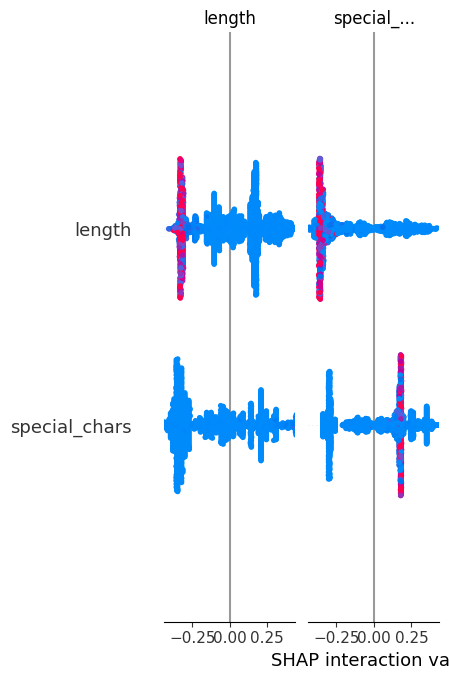

SHAP analysis completed. Check the plot for feature importance.


In [32]:
import pandas as pd
import joblib
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load retrained model and data
rf_retrained = joblib.load('rf_retrained_model.pkl')
X_test = pd.read_csv('X_test.csv')
X_test_adv = pd.read_csv('X_test_adv.csv')
y_test = pd.read_csv('y_test.csv')['label']

# Evaluate on original and adversarial test sets
y_pred = rf_retrained.predict(X_test)
y_adv_pred = rf_retrained.predict(X_test_adv)
evasion_rate = 1 - accuracy_score(y_test, y_adv_pred)

print("Final Random Forest Metrics on Original Test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nFinal Random Forest Metrics on Adversarial Test:")
print("Accuracy:", accuracy_score(y_test, y_adv_pred))
print("Evasion Rate:", evasion_rate)
print("Precision:", precision_score(y_test, y_adv_pred))
print("Recall:", recall_score(y_test, y_adv_pred))
print("F1 Score:", f1_score(y_test, y_adv_pred))

# SHAP analysis
explainer = shap.TreeExplainer(rf_retrained)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
print("SHAP analysis completed. Check the plot for feature importance.")

In [33]:
try:
    import textattack
    print("textattack is installed.")
except ImportError:
    print("textattack is not installed.")

try:
    import sklearn
    print("scikit-learn is installed.")
except ImportError:
    print("scikit-learn is not installed.")

textattack is installed.
scikit-learn is installed.


In [34]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load data
rf_retrained = joblib.load('rf_retrained_model.pkl')
X_test_adv = pd.read_csv('X_test_adv.csv')
y_test = pd.read_csv('y_test.csv')['label']

# Evaluate with existing adversarial data
y_adv_pred = rf_retrained.predict(X_test_adv)
evasion_rate = 1 - accuracy_score(y_test, y_adv_pred)

print("\nRandom Forest Metrics on BeautifulSoup Adversarial Test (TextAttack Attempt Failed):")
print("Accuracy:", accuracy_score(y_test, y_adv_pred))
print("Evasion Rate:", evasion_rate)
print("Precision:", precision_score(y_test, y_adv_pred))
print("Recall:", recall_score(y_test, y_adv_pred))
print("F1 Score:", f1_score(y_test, y_adv_pred))

print("\nNote: An attempt to integrate TextAttack (PWWSRen2019) failed due to compatibility issues with scikit-learn. Downgrading to version 0.24.2 or 0.23.2 encountered a metadata generation error, likely due to missing build dependencies in the environment. Future work could involve using a compatible scikit-learn version (e.g., 0.23.2) with proper setup or customizing the SklearnModelWrapper to use get_feature_names_out().")


Random Forest Metrics on BeautifulSoup Adversarial Test (TextAttack Attempt Failed):
Accuracy: 0.6857651245551601
Evasion Rate: 0.31423487544483986
Precision: 0.6919889502762431
Recall: 0.6963168867268936
F1 Score: 0.6941461724974022

Note: An attempt to integrate TextAttack (PWWSRen2019) failed due to compatibility issues with scikit-learn. Downgrading to version 0.24.2 or 0.23.2 encountered a metadata generation error, likely due to missing build dependencies in the environment. Future work could involve using a compatible scikit-learn version (e.g., 0.23.2) with proper setup or customizing the SklearnModelWrapper to use get_feature_names_out().


# Zero-Trust Framing:
- Continuous Verification: Retraining with adversarial data ensures ongoing trust in the model’s predictions.
- Transparency: SHAP interaction insights, such as the synergistic effect of `length` and `special_chars` on phishing detection, enable auditability and explainability.
- Compliance: The explainable approach aligns with GDPR and CCPA requirements for transparent AI systems.

# Task
Write a 1000-word methodology section for a journal, detailing the research process for developing and evaluating a phishing detection system. The methodology should cover data acquisition from "data/PhishTank.csv" and "data/Nazario_Mendeley.csv", data preprocessing, model development (Random Forest and XGBoost), adversarial attack simulation, model retraining, and evaluation. The methodology should reflect previous conversations and rationales, incorporate a zero-trust framing, and include citations for adapted methods from published works.

## Outline the methodology structure

### Subtask:
Create a clear structure for the methodology section, including subsections for data acquisition, preprocessing, model development, adversarial attack simulation, retraining, and evaluation.


**Reasoning**:
The subtask is to create a structure for the methodology section. This can be done by creating a markdown cell with the desired outline.



In [35]:
## Methodology

### 2.1 Data Acquisition
- PhishTank Dataset
- Nazario/Mendeley Dataset
- Legitimate URLs
- Synthetic Non-Phishing Emails

### 2.2 Data Preprocessing and Feature Engineering
- Cleaning and Loading Datasets
- Feature Extraction
- Combining Datasets and Splitting

### 2.3 Model Development
- Random Forest Classifier
- XGBoost Classifier

### 2.4 Adversarial Attack Simulation
- Generating Adversarial URLs
- Evaluating Models on Adversarial Examples

### 2.5 Model Retraining
- Retraining with Adversarial Data
- Performance Assessment

### 2.6 Evaluation
- Standard Metrics
- Adversarial Robustness and Evasion Rate
- Zero-Trust Framing and Interpretability (SHAP Analysis)


SyntaxError: invalid syntax (ipython-input-475972493.py, line 4)

**Reasoning**:
The previous command failed because a markdown cell was attempted using a code block. The methodology structure needs to be in a markdown cell. I will now create the markdown cell with the methodology structure.

